### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
# % matplotlib inline

import numpy as np
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [3]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
453,PSID269,0,23,13,1,0,0,0,172.4155,272.1290,582.2243
443,PSID259,0,24,12,0,0,1,0,9051.8130,327.6290,8547.1710
568,PSID384,0,31,4,0,1,0,1,0.0000,0.0000,1161.4930
36,NSW37,1,25,5,1,0,0,1,0.0000,0.0000,6181.8800
122,NSW123,1,19,9,1,0,0,1,0.0000,798.9079,17685.1800
112,NSW113,1,20,12,1,0,0,0,989.2678,165.2077,0.0000
179,NSW180,1,29,10,0,1,0,1,0.0000,8853.6740,5112.0140
539,PSID355,0,19,9,1,0,0,1,384.0163,0.0000,0.0000
497,PSID313,0,34,12,0,0,0,0,8125.0790,0.0000,6032.0800
339,PSID155,0,35,8,0,0,1,1,2241.4010,2399.0320,9460.4060


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9338
Date:                Fri, 21 Jan 2022   Prob (F-statistic):              0.334
Time:                        19:30:06   Log-Likelihood:                -6346.4
No. Observations:                 614   AIC:                         1.270e+04
Df Residuals:                     612   BIC:                         1.271e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6984.1697    360.710     19.362      0.0

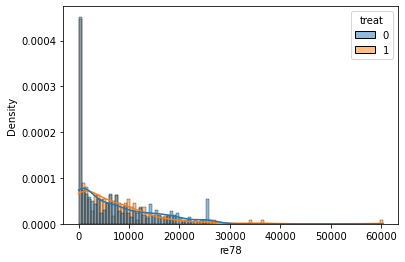

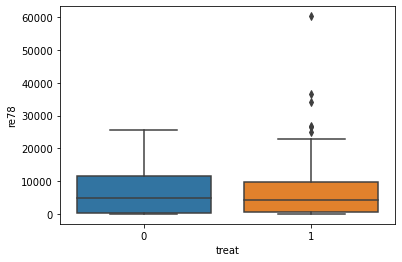

In [14]:
def naive_analysis(df):
    print(smf.ols('re78 ~ treat', data=df).fit().summary())

    print("\n\n\n0:", df[df.treat == 0].re78.describe())
    print("\n\n\n1:", df[df.treat == 1].re78.describe())

    sns.histplot(x="re78", hue="treat", bins=100, kde=True, stat="density", common_norm=False, data=df)
    plt.show()
    sns.boxplot(y="re78", x="treat", data=df)
    plt.show()

naive_analysis(df)

**Comment:** We could naively guess that the mean of the treated group is lower so the education did not help but did the opposite. But in the regression we see this is not significant, and R^2 is very low anyways so there is still a lot of variance to explain.

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

treat=0:               age        educ       black      hispan     married    nodegree  \
count  429.000000  429.000000  429.000000  429.000000  429.000000  429.000000   
mean    28.030303   10.235431    0.202797    0.142191    0.512821    0.596737   
std     10.786653    2.855238    0.402552    0.349654    0.500419    0.491126   
min     16.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     19.000000    9.000000    0.000000    0.000000    0.000000    0.000000   
50%     25.000000   11.000000    0.000000    0.000000    1.000000    1.000000   
75%     35.000000   12.000000    0.000000    0.000000    1.000000    1.000000   
max     55.000000   18.000000    1.000000    1.000000    1.000000    1.000000   

               re74          re75          re78  
count    429.000000    429.000000    429.000000  
mean    5619.236506   2466.484443   6984.169742  
std     6788.750796   3291.996183   7294.161791  
min        0.000000      0.000000      0.000000  
25%        

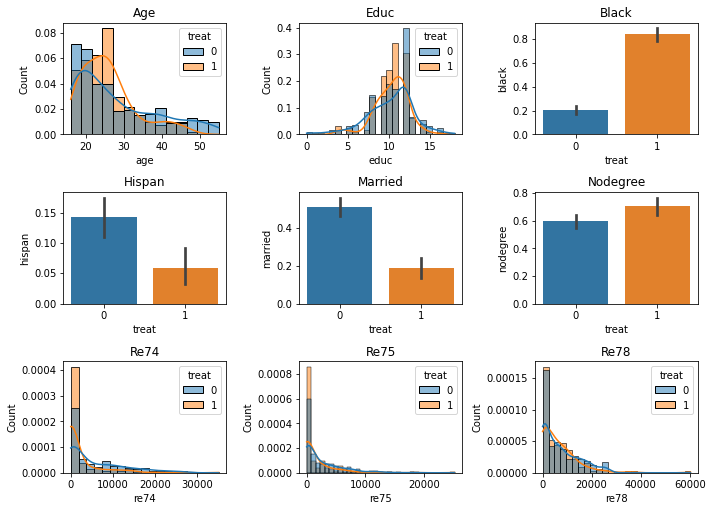

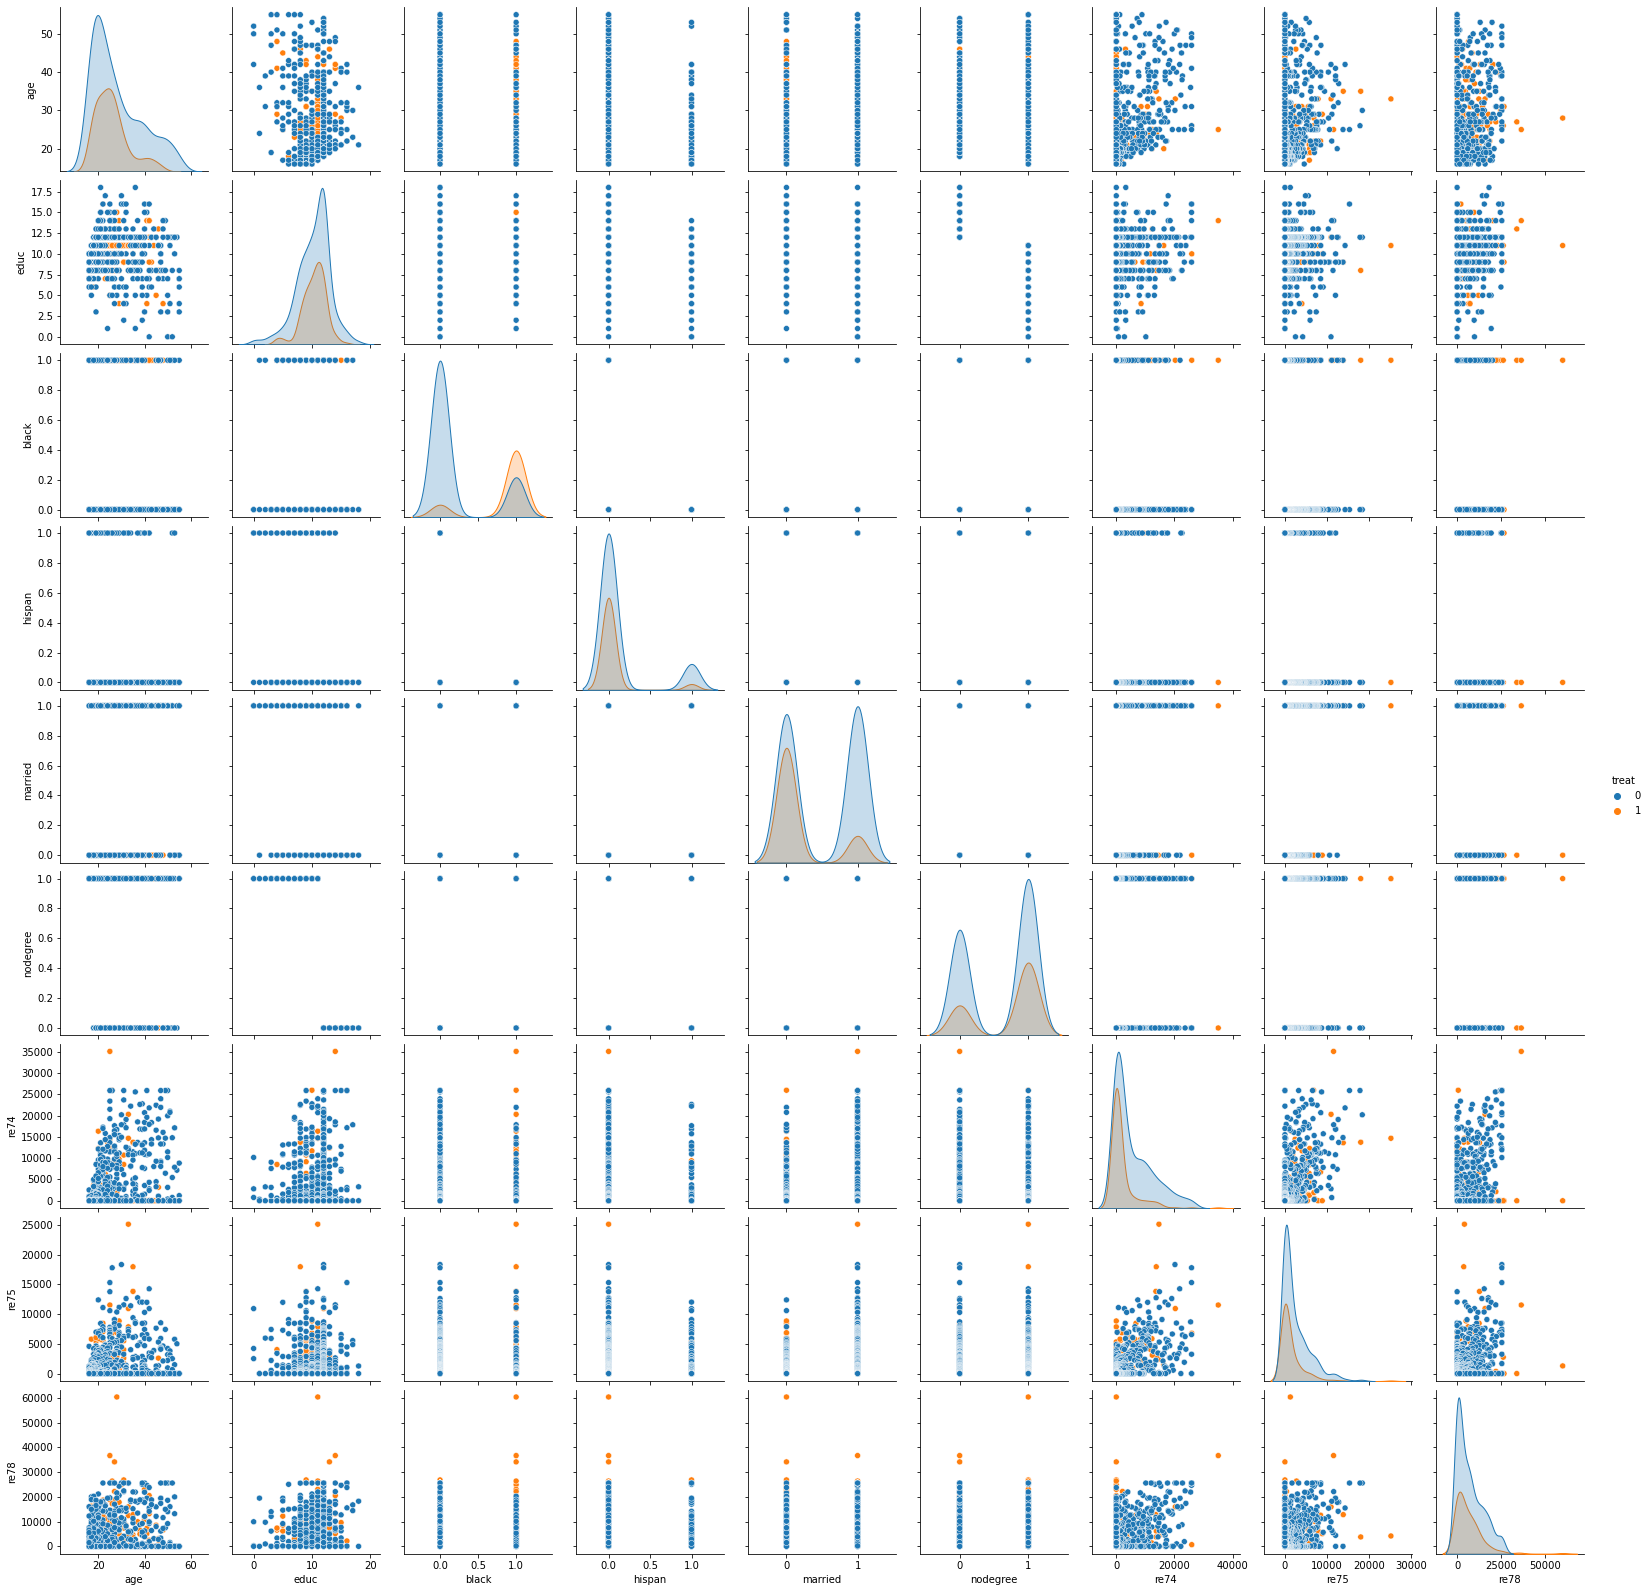

In [5]:
interesting_features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']
categorical_features = ['black', 'hispan', 'married', 'nodegree']

def compare_treatments(df):
    fig, axes = plt.subplots(3, 3, figsize=(10, 7.2))
    axes = [a for aa in axes for a in aa]  # flatten
    for i, feature in enumerate(interesting_features):
        ax = axes[i]
        ax.set_title(feature.title())
        ax.set_xlabel(feature)
        ax.set_ylabel("Count")
        if feature in categorical_features:
            sns.barplot(y=feature, x="treat", data=df, ax=ax)
        else:
            sns.histplot(x=feature, kde=True, stat="density", common_norm=False, hue="treat", data=df, ax=ax)

    print(f"treat=0: {df[df.treat == 0][interesting_features].describe()}\n treat=1: {df[df.treat == 1][interesting_features].describe()}")

    fig.tight_layout()
    plt.show()
    plt.close()

compare_treatments(df)
sns.pairplot(df, hue="treat")

**Comment:** The ones with a treatment earned much more that hey did before the education, and things haven't changed much. Does it really make sense to compare only the end result and not look at where they started? In this case it does not, and `re74` and `re75` (a.k.a. the history) must be taken into account as well. Also, looking at the numbers, the ones who participated in the education could probably have participated exactly because of their situation, i.e. not earning much money and having a degree less frequently, which is in line with the numbers. The naive researcher is wrong and ignorant after all.

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [6]:

features_to_standardize = ['age', 'educ', 're74', 're75']

df[features_to_standardize] = StandardScaler().fit_transform(df[features_to_standardize])

df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
317,PSID133,0,2.394052,0.659234,0,0,1,0,2.540496,0.290097,16015.600
392,PSID208,0,-1.150920,-0.483108,0,0,0,1,-0.704120,-0.302510,2451.548
400,PSID216,0,0.469639,-1.625450,0,1,1,1,-0.552771,-0.348723,0.000
137,NSW138,1,-0.948350,-0.102327,1,0,0,1,-0.372973,-0.121672,11141.390
200,PSID16,0,1.482488,-3.910134,0,1,1,1,-0.271868,2.655632,9922.934
376,PSID192,0,-0.441926,1.040015,0,0,0,0,-0.611192,-0.239987,4975.505
37,NSW38,1,-0.441926,0.659234,1,0,1,0,-0.704120,-0.663511,5911.551
371,PSID187,0,-0.948350,0.278454,1,0,0,1,-0.520080,-0.214435,3683.972
259,PSID75,0,1.077348,-0.863888,0,0,1,1,1.032759,0.907713,0.000
157,NSW158,1,-0.644495,0.659234,1,0,0,0,0.296034,0.348458,9371.037


Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Fri, 21 Jan 2022   Pseudo R-squ.:                  0.3508
Time:                        19:22:50   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8509      0.350     -8.147      0.000      -3.537      -2.165
age            0.1558      0.

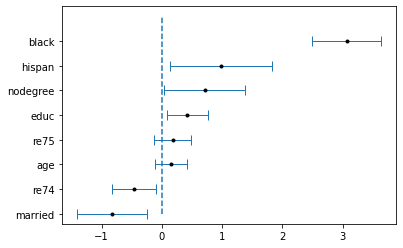

In [7]:
interesting_features_2 = interesting_features.copy()
interesting_features_2.pop()  # r78

res = smf.logit(f"treat ~ {' + '.join(interesting_features_2)}", data=df).fit()
print(res.summary())

variables = res.params.index
coefficients = res.params.values
p_values = res.pvalues
standard_errors = res.bse.values

l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
plt.errorbar(l1, np.array(range(len(l1))), xerr=2 * np.array(l3), linewidth=1,
             linestyle='none', marker='o', markersize=3,
             markerfacecolor='black', markeredgecolor='black', capsize=5)
plt.vlines(0, 0, len(l1), linestyle='--')
plt.yticks(range(len(l2)), l2);

In [8]:
df["propensity"] = res.predict(df)
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
365,PSID181,0,-0.340641,0.659234,0,0,1,0,0.476704,-0.193775,3262.820,0.023838
526,PSID342,0,-0.745780,-0.102327,0,0,0,1,-0.485875,-0.663511,6290.682,0.100278
504,PSID320,0,-0.441926,-0.863888,0,0,1,1,0.008128,-0.663511,0.000,0.028442
428,PSID244,0,0.874778,-0.863888,0,0,1,1,-0.284581,-0.485729,0.000,0.040751
56,NSW57,1,0.976063,-0.483108,1,0,0,1,-0.704120,-0.663511,1067.506,0.746405
37,NSW38,1,-0.441926,0.659234,1,0,1,0,-0.704120,-0.663511,5911.551,0.450948
301,PSID117,0,-0.441926,0.659234,0,0,1,0,1.512535,0.393939,3818.445,0.016208
138,NSW139,1,0.165784,0.659234,1,0,0,0,0.977089,-0.111647,0.000,0.511496
146,NSW147,1,-0.847065,-0.863888,1,0,0,1,-0.704120,0.143371,9970.681,0.684870
307,PSID123,0,-0.239356,0.659234,0,0,1,0,2.612841,0.370561,7981.201,0.010054


## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [9]:
edges = []

g = nx.Graph()
for cid, c in df[df.treat == 0].iterrows():
    for tid, t in df[df.treat == 1].iterrows():
        edges += [[cid, tid, 1 - np.abs(c["propensity"] - t['propensity'])]]

g.add_weighted_edges_from(edges)
matching = nx.max_weight_matching(g)

treat=0:               age        educ      black      hispan     married    nodegree  \
count  185.000000  185.000000  185.00000  185.000000  185.000000  185.000000   
mean    -0.208697    0.128200    0.47027    0.216216    0.210811    0.637838   
std      1.072238    1.012209    0.50047    0.412781    0.408991    0.481930   
min     -1.150920   -3.529353    0.00000    0.000000    0.000000    0.000000   
25%     -0.948350   -0.483108    0.00000    0.000000    0.000000    0.000000   
50%     -0.745780    0.278454    0.00000    0.000000    0.000000    1.000000   
75%      0.165784    0.659234    1.00000    0.000000    0.000000    1.000000   
max      2.799192    2.943919    1.00000    1.000000    1.000000    1.000000   

             re74        re75          re78  
count  185.000000  185.000000    185.000000  
mean    -0.342275   -0.173153   5454.776050  
std      0.654902    0.799380   6063.836916  
min     -0.704120   -0.663511      0.000000  
25%     -0.704120   -0.663511      0.000

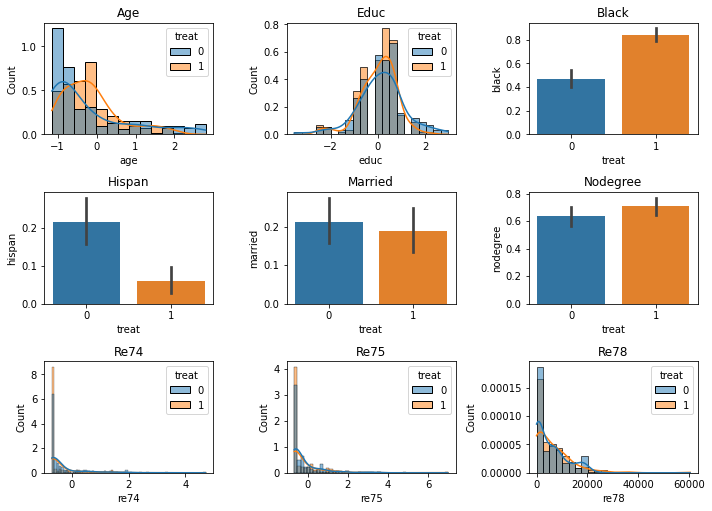

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
574,PSID390,0,2.090198,1.040015,0,0,1,0,-0.704120,-0.663511,0.000,0.062592
70,NSW71,1,-0.036786,-0.483108,1,0,0,1,-0.704120,-0.663511,0.000,0.715400
367,PSID183,0,-1.049635,-0.102327,0,0,0,1,-0.616337,-0.200299,6231.573,0.109162
565,PSID381,0,-0.644495,1.040015,1,0,0,0,-0.704120,-0.663511,17941.080,0.682444
103,NSW104,1,-0.948350,0.278454,1,0,0,1,-0.704120,-0.663511,4814.627,0.750705


In [10]:
control_ids = [node[0] for node in matching]
treat_ids = [node[1] for node in matching]
df_matched = df[df.index.isin(control_ids + treat_ids)]

compare_treatments(df_matched)
df_matched.sample(5)

**Comment:** I am afraid that the matching is still not so good since the treated group is again very biased towards being black and non-hispanic. But more detailed analysis should be made to argue how influential these con-founders are.

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


**Comment:** As discussed above, race is highly unbalanced. I will now force the matching to match race as well!


treat=0:               age        educ       black      hispan     married    nodegree  \
count  116.000000  116.000000  116.000000  116.000000  116.000000  116.000000   
mean    -0.178236    0.032259    0.750000    0.094828    0.267241    0.629310   
std      1.033588    1.037969    0.434891    0.294248    0.444439    0.485085   
min     -1.150920   -3.529353    0.000000    0.000000    0.000000    0.000000   
25%     -0.948350   -0.483108    0.750000    0.000000    0.000000    0.000000   
50%     -0.644495    0.278454    1.000000    0.000000    0.000000    1.000000   
75%      0.292390    0.659234    1.000000    0.000000    1.000000    1.000000   
max      2.799192    2.563138    1.000000    1.000000    1.000000    1.000000   

             re74        re75          re78  
count  116.000000  116.000000    116.000000  
mean    -0.226567   -0.077991   5090.615206  
std      0.758357    0.910638   6002.464250  
min     -0.704120   -0.663511      0.000000  
25%     -0.704120   -0.663511  

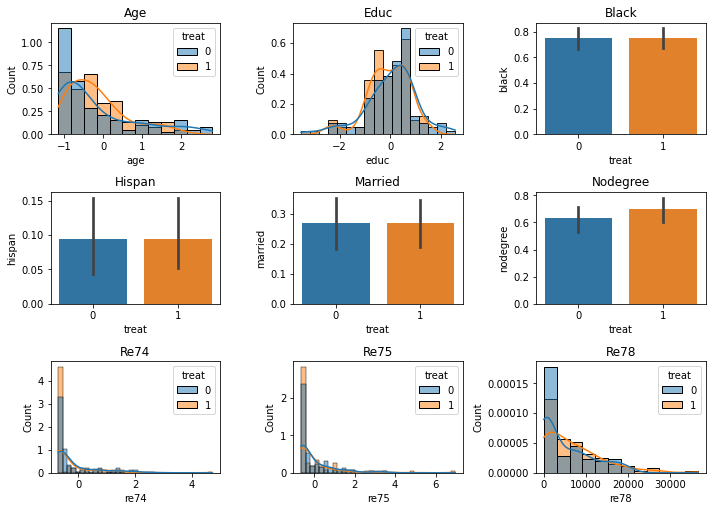

In [11]:
edges = []
g = nx.Graph()
for cid, c in df[df.treat == 0].iterrows():
    for tid, t in df[df.treat == 1].iterrows():
        if c.black != t.black or c.hispan != t.hispan or c.married != t.married:
            continue
        edges += [[cid, tid, 1 - np.abs(c["propensity"] - t['propensity'])]]
g.add_weighted_edges_from(edges)

matching = nx.max_weight_matching(g)
control_ids = [node[0] for node in matching]
treat_ids = [node[1] for node in matching]
df_matched = df[df.index.isin(control_ids + treat_ids)]

compare_treatments(df_matched)

# matching_filtered = [
#     m for m in matching
#     if df.loc[m[0]].black == df.loc[m[1]].black and df.loc[m[0]].married == df.loc[m[1]].married
# ]
#
# len(matching_filtered)

# control_ids_filtered = [node[0] for node in matching_filtered]
# treat_ids_filtered = [node[1] for node in matching_filtered]
# df_matched_filtered = df[df.index.isin(control_ids_filtered + treat_ids_filtered)]
#
# compare_treatments(df_matched_filtered)

**Comment:** Well, I did the matching again to force the pairs to be of same race and of same marital status. Now the pairs are much more similar! But there are not as many of them :'( Race and marital status fixed!

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.812
Date:                Fri, 21 Jan 2022   Prob (F-statistic):             0.0521
Time:                        19:30:17   Log-Likelihood:                -2366.4
No. Observations:                 232   AIC:                             4737.
Df Residuals:                     230   BIC:                             4744.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5090.6152    607.135      8.385      0.0

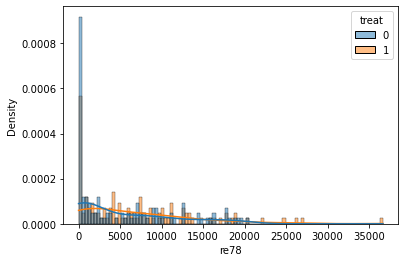

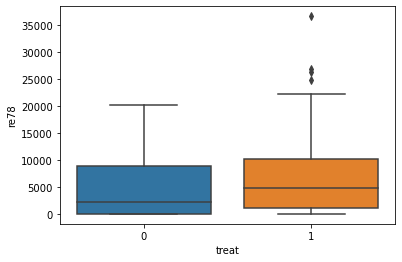

In [15]:
naive_analysis(df_matched)